Epoch 1/20 - Gen Loss: 2.5846, Disc Loss: 0.4587
Epoch 2/20 - Gen Loss: 2.1660, Disc Loss: 0.6591
Epoch 3/20 - Gen Loss: 1.8743, Disc Loss: 0.9091
Epoch 4/20 - Gen Loss: 1.6951, Disc Loss: 0.7448
Epoch 5/20 - Gen Loss: 1.5363, Disc Loss: 0.5878


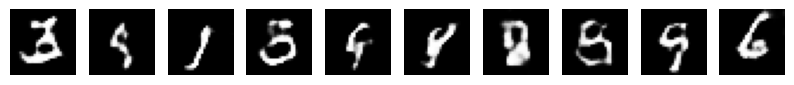

Epoch 6/20 - Gen Loss: 1.8053, Disc Loss: 0.7688
Epoch 7/20 - Gen Loss: 1.7514, Disc Loss: 0.6953
Epoch 8/20 - Gen Loss: 1.8079, Disc Loss: 0.6368
Epoch 9/20 - Gen Loss: 1.4872, Disc Loss: 0.7179
Epoch 10/20 - Gen Loss: 1.5850, Disc Loss: 0.7908


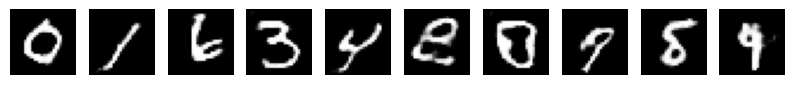

Epoch 11/20 - Gen Loss: 1.2470, Disc Loss: 1.2386
Epoch 12/20 - Gen Loss: 1.0901, Disc Loss: 1.1718
Epoch 13/20 - Gen Loss: 1.2834, Disc Loss: 1.1929
Epoch 14/20 - Gen Loss: 0.9792, Disc Loss: 1.3403
Epoch 15/20 - Gen Loss: 0.9970, Disc Loss: 1.1093


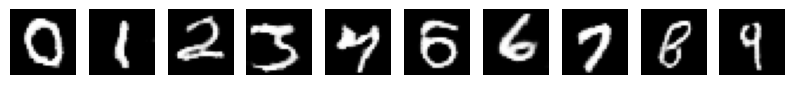

Epoch 16/20 - Gen Loss: 0.8691, Disc Loss: 1.5941
Epoch 17/20 - Gen Loss: 1.0830, Disc Loss: 1.0586
Epoch 18/20 - Gen Loss: 1.0207, Disc Loss: 1.3169
Epoch 19/20 - Gen Loss: 1.0187, Disc Loss: 1.2035
Epoch 20/20 - Gen Loss: 0.7881, Disc Loss: 1.2944


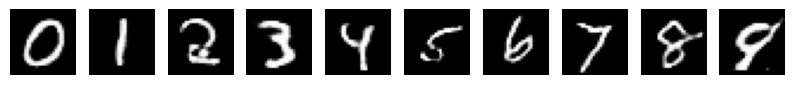

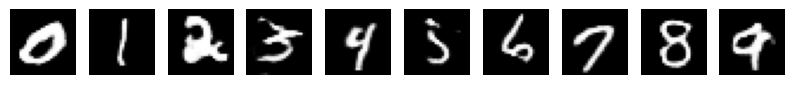

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define hyperparameters
LATENT_DIM = 100
IMG_SHAPE = (28, 28, 1)
NUM_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 20  # Reduced for speed

# Load dataset
(x_train, y_train), (_, _) = keras.datasets.mnist.load_data()
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1,1]
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
y_train = tf.one_hot(y_train, NUM_CLASSES)  # Convert labels to one-hot

# Create TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Build Generator
def build_generator():
    noise_input = layers.Input(shape=(LATENT_DIM,))
    label_input = layers.Input(shape=(NUM_CLASSES,))

    x = layers.Concatenate()([noise_input, label_input])
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(7 * 7 * 128, activation="relu")(x)
    x = layers.Reshape((7, 7, 128))(x)
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", activation="tanh")(x)

    return keras.Model([noise_input, label_input], x)

# Build Discriminator
def build_discriminator():
    img_input = layers.Input(shape=IMG_SHAPE)
    label_input = layers.Input(shape=(NUM_CLASSES,))

    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same")(img_input)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, label_input])
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model([img_input, label_input], x)

# Instantiate models
generator = build_generator()
discriminator = build_discriminator()

# Define loss & optimizers
loss_fn = keras.losses.BinaryCrossentropy(from_logits=False)
gen_optimizer = keras.optimizers.Adam(learning_rate=0.0002)
disc_optimizer = keras.optimizers.Adam(learning_rate=0.0002)

# Training step function
@tf.function
def train_step(real_images, real_labels):
    batch_size = tf.shape(real_images)[0]
    noise = tf.random.normal([batch_size, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator([noise, real_labels], training=True)

        real_output = discriminator([real_images, real_labels], training=True)
        fake_output = discriminator([fake_images, real_labels], training=True)

        gen_loss = loss_fn(tf.ones_like(fake_output), fake_output)
        disc_loss = loss_fn(tf.ones_like(real_output), real_output) + loss_fn(tf.zeros_like(fake_output), fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training function
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, label_batch)

        print(f"Epoch {epoch+1}/{epochs} - Gen Loss: {gen_loss:.4f}, Disc Loss: {disc_loss:.4f}")

        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator, epoch + 1)

# Function to generate and save images
def generate_and_save_images(model, epoch, num_images=10):
    noise = tf.random.normal([num_images, LATENT_DIM])
    labels = tf.one_hot(np.arange(num_images), NUM_CLASSES)
    generated_images = model([noise, labels], training=False)

    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i, :, :, 0], cmap="gray")
        ax.axis("off")
    plt.show()

# Train the CGAN
train(dataset, EPOCHS)

# Generate final sample images
generate_and_save_images(generator, "final")